In [13]:
# Parameters
artificial_humans = "../../artifacts/artificial_humans/01_rnn_edge_features/model/rnn_True__edge_True__global_features_False.pt"
artificial_humans_valid = "../../artifacts/artificial_humans/02_valid/model/rnn_True.pt"
artificial_humans_model = "graph"
manager = "../../artifacts/manager_v3/17_model/model/rnn_True__edge_False__global_features_False__run_0.pt"
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 10000


In [14]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)
artifical_humans_valid = GraphNetwork.load(artificial_humans_valid, device=device)

mg = ArtificalManager.load(manager, device=th.device('cpu'))


n_agents_set = list(range(3, 9))

dfs = []
for e, n_agents in enumerate(n_agents_set):

    env = ArtificialHumanEnv(
        artifical_humans=artifical_humans, artifical_humans_valid=artifical_humans_valid, 
        n_agents=4, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=n_episodes, device=device)

    recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)

    state = env.reset()
    for round_number in count():
        _state = {**state, **env.get_batch_structure()}
        encoded = mg.encode_pure(_state)

        q_values = mg.get_q(encoded, first=round_number == 0)

        action = q_values.argmax(-1)

        state = env.punish(action)

        recorder.add(**{k: v.squeeze(-1) for k, v in state.items()}, episode_step=round_number)
        state, reward, done = env.step()
        if done:
            break
# recorder.next_episode(episode)

In [16]:
columns = ['round_number','participant_code']
# columns = ['round_number']

punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')

df_sim = punishments.merge(common_good).merge(contributions)
df_sim['data_source'] = 'simulation'

data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
experiment_names = ['trail_rounds_2']

df_pilot = pd.read_csv(data_file)

df_pilot = df_pilot[df_pilot['experiment_name'].isin(experiment_names)]
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment']]


df_pilot['data_source'] = 'pilot'


df = pd.concat([df_sim, df_pilot]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source'], 
    value_vars=['punishment', 'contribution'])

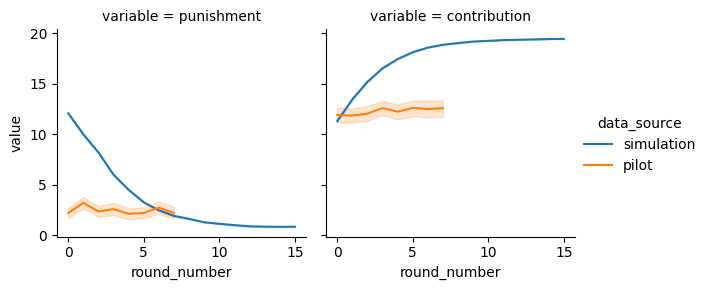

In [17]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=3, aspect=1,
)


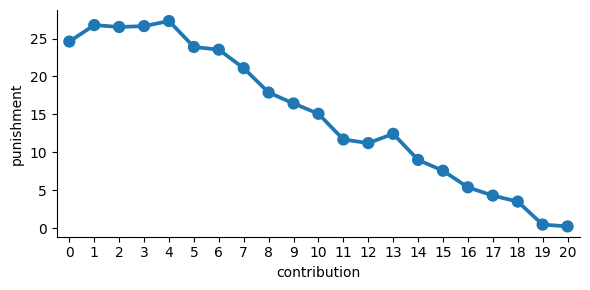

In [18]:
g = sns.catplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    kind="point",
    height=3, aspect=2,
)

In [19]:
df_sim.groupby(['round_number', 'contribution'])['punishment'].mean()[0]

contribution
0     29.0
1     29.0
2     29.0
3     29.0
4     29.0
5     21.0
6     21.0
7     16.0
8     10.0
9     10.0
10    10.0
11    10.0
12    10.0
13    10.0
14    10.0
15     5.0
16     3.0
17     3.0
18     3.0
19     3.0
20     3.0
Name: punishment, dtype: float64

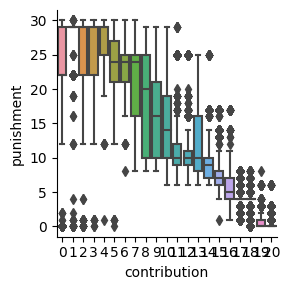

In [20]:
g = sns.catplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    kind="box",
    height=3, aspect=1,
)

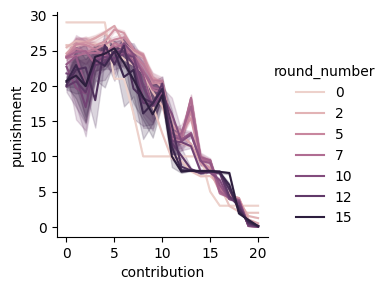

In [21]:
g = sns.relplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    hue='round_number',
    kind="line",
    height=3, aspect=1,
)